## Imports

In [34]:
import collections
import os
import string
import sys
import nltk

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

nltk.download('punkt')

import sys
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alicemahiant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:
data_path = "../data/txt/"

In [36]:
DECADE = '1962'

In [37]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [38]:
texts = [open(data_path + f).read() for f in files]

In [39]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

In [40]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

In [41]:
tfidf_vectors = vectorizer.fit_transform(texts)

In [42]:
# Détail de la matrice
tfidf_vectors

<1000x2997 sparse matrix of type '<class 'numpy.float64'>'
	with 591250 stored elements in Compressed Sparse Row format>

In [43]:
N_CLUSTERS = 3

In [44]:
km_model = KMeans(n_clusters=N_CLUSTERS)

In [45]:
clusters = km_model.fit_predict(tfidf_vectors)

In [46]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [47]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

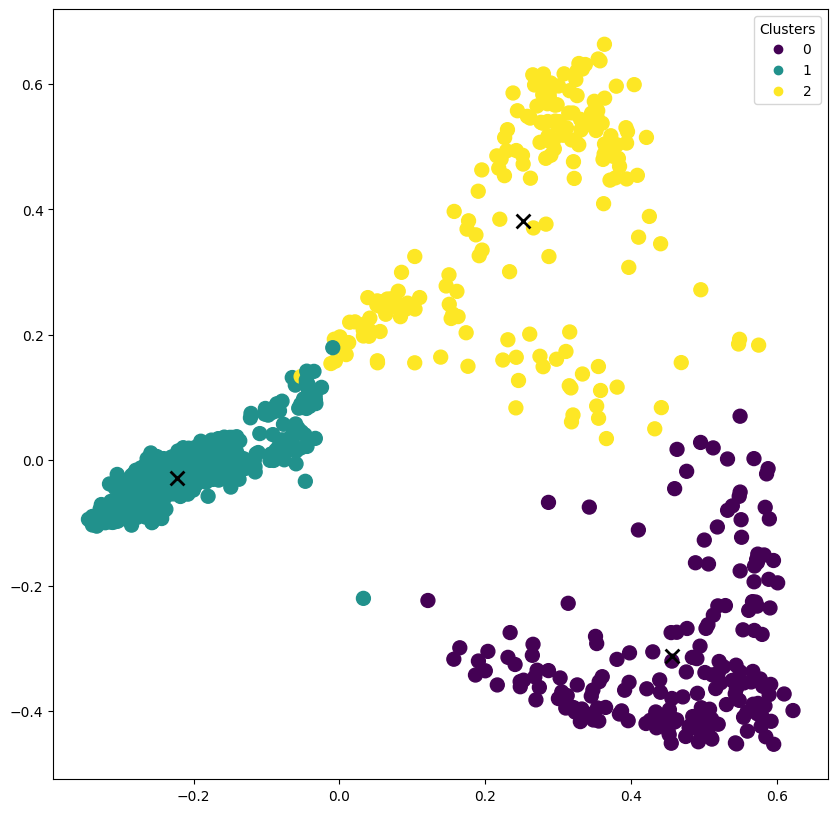

In [48]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

In [49]:
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [50]:
infile = f"../data/sents.txt"
sentences = MySentences(infile)

In [51]:
bigram_phrases = Phrases(sentences)

In [52]:
type(bigram_phrases.vocab)

dict

In [53]:
len(bigram_phrases.vocab.keys())

15761694